这个文件将使用pytorch修改模型结构，包括删除某个模块（group），以及修改瓶颈维度。首先通过运行第一个代码块准备好model和dataset，第一个代码块的代码来自lab_demo.py

In [10]:
# 导入必要的库和函数
# 用于加载和处理序列到序列的语言模型
import hiddenlayer as h
import argparse
import logging
import re
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForSeq2SeqLM, AutoModelForSequenceClassification
# 导入必要的库
from adapters import AdapterTrainer
from transformers import TrainingArguments, EvalPrediction
import numpy as np
from transformers import RobertaConfig
from transformers import RobertaTokenizer
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from adapters import AutoAdapterModel, AdapterArguments, AdapterTrainer, AdapterConfig, ConfigUnion, LoRAConfig, SeqBnConfig, PrefixTuningConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss

from pruning_methods import *
# from roberta_train_demo import plot_small_value_ratios


def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    logger.info(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )


# Define global variables
device = None
dataset = None
model = None
tokenizer = None
train_dataloader = None
valid_dataloader = None
optimizer = None
scheduler = None
loss_fn = None
dummy_input = None


def get_dataset(name):
    global dataset, model
    if name in ['axb', 'axg', 'cb', 'copa', 'multirc', 'record', 'rte', 'wic', 'wsc']:
        dataset = load_dataset("super_glue", name)
    else:
        dataset = load_dataset(name)
    if dataset['test']:
        # 获取分类信息
        num_labels = dataset["test"].features["label"].num_classes
        # 初始化分类头
        model.add_classification_head(name, num_labels=num_labels)
        model = model.to(device)
    else:
        logger.info("No test dataset available for this task.")


def preprocessing(task_name, configs=None):
    global device, dataset, model, tokenizer, train_dataloader, valid_dataloader, optimizer, scheduler, loss_fn
    logger.info("Start Preprocessing...")
    # 定义一些参数
    model_name_or_path = "roberta-base"
    output_dir = "out/"

    # 检查是否有可用的GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 添加lora和adapter
    # 加载预训练的序列到序列语言模型
    model = AutoAdapterModel.from_pretrained(model_name_or_path)
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

    print_trainable_parameters(model)
    # 加载数据集
    get_dataset(task_name)

    if configs == None:
        # 配置PEFT的参数
        lora_config = LoRAConfig(
            r=32,  # 设置LoRA的rank
            alpha=32,  # LoRA的alpha值，决定参数增加的数量
            dropout=0.1,  # LoRA层的dropout比例
            # leave_out=[6, 7, 8, 9, 10, 11],  # 指定需要转换的层 #important
        )

        bn_config = SeqBnConfig(
            reduction_factor=16,  # 设置瓶颈维度
            # leave_out=[6, 7, 8, 9, 10, 11]  # 指定需要转换的层 #important
        )

        config_list = [lora_config, bn_config]
    else:
        config_list = configs

    peft_config = ConfigUnion(*[config_list[i]
                              for i in range(len(config_list))])

    model.add_adapter(task_name, peft_config)
    model.train_adapter(task_name)
    model.set_active_adapters(task_name)

    model = model.to(device)

    print_trainable_parameters(model)
    if 'train' not in dataset:
        dataset = dataset['test'].train_test_split(test_size=0.5)

    # 定义训练和验证的数据加载器
    train_dataloader = DataLoader(
        dataset['train'], batch_size=16, shuffle=True)
    valid_dataloader = DataLoader(
        dataset['test'], batch_size=16, shuffle=False)

    # 定义优化器和学习率调度器
    optimizer = AdamW(model.parameters(), lr=1e-7)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)

    # 定义损失函数
    loss_fn = CrossEntropyLoss()
    logger.info("Start training...")


def train_epoch(epoch_num):
    global dummy_input
    # 重置优化器
    optimizer = AdamW(model.parameters(), lr=1e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)
    # 开始训练
    for epoch in range(epoch_num):
        model.train()
        for batch in tqdm(train_dataloader, desc=f"Training epoch {epoch+1}", unit="batch"):
            text_fields = [
                field for field in dataset['test'].column_names if field not in ['label', 'idx']]
            batch_fields = [batch[field] for field in text_fields]

            inputs = tokenizer(*batch_fields,
                               return_tensors='pt', padding=True, truncation=True, max_length=512)
            inputs = {name: tensor.to(device) for name,
                      tensor in inputs.items()}  # 将输入数据移动到GPU上
            batch['label'] = batch['label'].to(device)
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, batch['label'])
            loss.backward()
            optimizer.step()
            scheduler.step()
            model.zero_grad()

        # 验证
        model.eval()
        total_loss, total_correct, total_count = 0, 0, len(
            dataset['test'])
        for batch in valid_dataloader:
            with torch.no_grad():
                text_fields = [
                    field for field in dataset['test'].column_names if field not in ['label', 'idx']]
                batch_fields = [batch[field] for field in text_fields]

                inputs = tokenizer(*batch_fields,
                                   return_tensors='pt', padding=True, truncation=True, max_length=512)
                inputs = {name: tensor.to(device) for name,
                          tensor in inputs.items()}  # 将输入数据移动到GPU上
                if (dummy_input == None):
                    dummy_input = inputs
                batch['label'] = batch['label'].to(device)
                outputs = model(**inputs)
                loss = loss_fn(outputs.logits, batch['label'])
                total_loss += loss.item()
                total_correct += (outputs.logits.argmax(dim=-1)
                                  == batch['label']).sum().item()
        logger.info(
            f'Epoch {epoch+1} || Validation loss: {total_loss/total_count:.6f} || Validation accuracy: {total_correct/total_count:.6f}')


def get_trainable_parameters(model):
    names = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            # logger.info(name)
            names.append(name)
    return names


def plot_small_value_ratios(groups, model):
    group_names = []
    small_value_ratios = []
    for group, names in groups.items():
        num_small_values = 0
        total_values = 0
        for name in names:
            weights = model.state_dict()[name]
            num_small_values += torch.lt(torch.abs(weights),
                                         0.001).sum().item()
            total_values += weights.numel()
        small_value_ratios.append(num_small_values / total_values)
        group_names.append(group)

    plt.bar(group_names, small_value_ratios)
    plt.xlabel('Group')
    plt.ylabel('Ratio of small values')
    plt.title('Ratio of weights less than 0.001 in each group')
    plt.show()


def plot_total_parameters(groups, model):
    group_names = []
    total_parameters = []
    for group, names in groups.items():
        total_values = 0
        for name in names:
            weights = model.state_dict()[name]
            total_values += weights.numel()
        total_parameters.append(total_values)
        group_names.append(group)

    plt.bar(group_names, total_parameters)
    plt.xlabel('Group')
    plt.ylabel('Total parameters')
    plt.title('Total parameters in each group')
    plt.show()


def set_weights_to_zero_and_untrainable(group, model):
    for name in group:
        # 获取权重
        weights = model.state_dict()[name]
        # 将权重设置为全 0
        weights.zero_()
        # 将修改后的权重重新赋值给模型中的对应模块

        name = re.sub(r'\.(\d+)', r'[\1]', name)
        exec('model.'+name+'= Parameter(data=weights, requires_grad=False)')


def reinitialize_trainable_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            if len(param.shape) == 1:  # bias
                torch.nn.init.zeros_(param)
            else:  # weights
                torch.nn.init.xavier_uniform_(param)


def main():
    global model, dataset
    parser = argparse.ArgumentParser(description='Lab demo script')
    parser.add_argument('--run_baseline_lora', action='store_true',
                        help='Run the baseline: lora or adapter')
    parser.add_argument('--run_baseline_adapter', action='store_true',
                        help='Run the baseline: lora or adapter')
    parser.add_argument('--f')
    args = parser.parse_args()
    # 创建一个日志记录器
    logger = logging.getLogger('lab')
    logger.setLevel(logging.INFO)  # 设置日志级别

    # 创建一个文件处理器，将日志写入到文件中
    file_handler = logging.FileHandler('output.log', mode='w')
    file_handler.setLevel(logging.INFO)

    # 创建一个格式器，定义日志的格式
    formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)

    # 将文件处理器添加到日志记录器中
    logger.addHandler(file_handler)

    task_names = ['axb']
    task_names = ['rotten_tomatoes']
    # task_names = ['axg', 'cb', 'copa',
    #   'multirc', 'record', 'rte', 'wic', 'wsc']
    # 配置PEFT的参数
    lora_config = LoRAConfig(
        r=64,  # 设置LoRA的rank
        alpha=32,  # LoRA的alpha值，决定参数增加的数量
        dropout=0.1,  # LoRA层的dropout比例
        # leave_out=[6, 7, 8, 9, 10, 11],  # 指定需要转换的层 #important
    )

    bn_config = SeqBnConfig(
        reduction_factor=16,  # 设置瓶颈维度
        # leave_out=[6, 7, 8, 9, 10, 11]  # 指定需要转换的层 #important
    )

    configs = [lora_config, bn_config]

    if args.run_baseline_lora:
        for task in task_names:
            preprocessing(task, [lora_config])
            logger.info(f'Task:{task}')
            train_epoch(10)
    elif args.run_baseline_adapter:
        for task in task_names:
            model = None
            dataset = None
            preprocessing(task, [bn_config])
            logger.info(f'Task:{task}')
            train_epoch(10)
    else:
        for task in task_names:
            model = None
            dataset = None
            preprocessing(task, configs)
            torch.cuda.empty_cache()
            logger.info(f'Task:{task}')
            train_epoch(1)


main()

Some weights of RobertaAdapterModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['heads.default.3.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\13061\AppData\Roaming\Python\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training epoch 1: 100%|██████████| 534/534 [00:22<00:00, 23.67batch/s]


In [46]:
# 网络可视化
import netron
model.to('cuda')
torch.onnx.export(model, dummy_input, "model.onnx")
netron.start('model.onnx')

C:\Users\13061\AppData\Roaming\Python\Python311\site-packages\adapters\composition.py:242: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tensor is not None and hidden_states.shape[0] >= tensor.shape[0]:
C:\Users\13061\AppData\Roaming\Python\Python311\site-packages\adapters\composition.py:253: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  max_bsz = max(query.shape[0], key.shape[0], value.shape[0])
C:\Users\13061\AppData\Roaming\Python\Python311\site-packages\adapters\composition.py:227: TracerWarning: Converting a tensor to a Python boolean might cau

Serving 'model.onnx' at http://localhost:8080


('localhost', 8080)

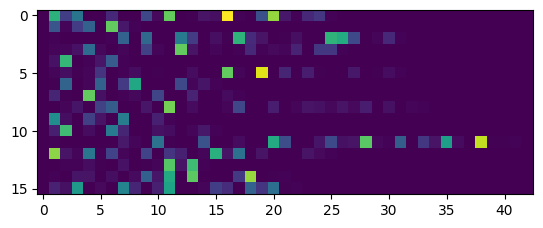

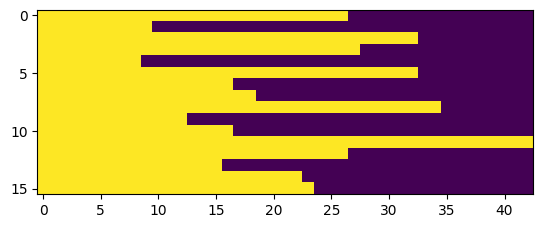

dict_keys(['input_ids', 'attention_mask'])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 

In [24]:
# 可视化输入，16*43,16=batch_size,43=sequence_length
import torch
import matplotlib.pyplot as plt
plt.imshow(dummy_input['input_ids'].cpu())
plt.show()
plt.imshow(dummy_input['attention_mask'].cpu())
plt.show()

In [30]:
names=get_trainable_parameters(model)
names
groups=group_parameters_by_prefix(names,['lora'],print_names=True,task_name='rotten_tomatoes')
groups

{'roberta.encoder.layer.0.attention.self.loras.': ['roberta.encoder.layer.0.attention.self.query.loras.rotten_tomatoes.lora_A',
  'roberta.encoder.layer.0.attention.self.query.loras.rotten_tomatoes.lora_B',
  'roberta.encoder.layer.0.attention.self.value.loras.rotten_tomatoes.lora_A',
  'roberta.encoder.layer.0.attention.self.value.loras.rotten_tomatoes.lora_B'],
 'roberta.encoder.layer.1.attention.self.loras.': ['roberta.encoder.layer.1.attention.self.query.loras.rotten_tomatoes.lora_A',
  'roberta.encoder.layer.1.attention.self.query.loras.rotten_tomatoes.lora_B',
  'roberta.encoder.layer.1.attention.self.value.loras.rotten_tomatoes.lora_A',
  'roberta.encoder.layer.1.attention.self.value.loras.rotten_tomatoes.lora_B'],
 'roberta.encoder.layer.2.attention.self.loras.': ['roberta.encoder.layer.2.attention.self.query.loras.rotten_tomatoes.lora_A',
  'roberta.encoder.layer.2.attention.self.query.loras.rotten_tomatoes.lora_B',
  'roberta.encoder.layer.2.attention.self.value.loras.rotten_

In [44]:
import adapters

group = ['roberta.encoder.layer.0.attention.self.query.loras.rotten_tomatoes.lora_A',
         'roberta.encoder.layer.0.attention.self.query.loras.rotten_tomatoes.lora_B',
         'roberta.encoder.layer.0.attention.self.value.loras.rotten_tomatoes.lora_A',
         'roberta.encoder.layer.0.attention.self.value.loras.rotten_tomatoes.lora_B']
module_name = 'roberta.encoder.layer.0.attention.self.query.loras.rotten_tomatoes'
name = re.sub(r'\.(\d+)', r'[\1]', module_name)
exec('module=model.'+name,
     globals(), locals())
print(type(module))
print(module)
print(adapters.methods.lora.LoRA.__dict__)

module_name = 'roberta.encoder.layer.0.attention.self.query.loras.rotten_tomatoes.lora_A'
name = re.sub(r'\.(\d+)', r'[\1]', module_name)
exec('module=model.'+name,
     globals(), locals())
print(type(module))
print(module)
print(module.size())

name='roberta.encoder.layer.0.attention.self.query.loras.rotten_tomatoes.lora_A'
name = re.sub(r'\.(\d+)', r'[\1]', name)
weights = torch.rand(32, 768)
exec('model.'+name+'= Parameter(data=weights, requires_grad=True)')
name='roberta.encoder.layer.0.attention.self.query.loras.rotten_tomatoes.lora_B'
name = re.sub(r'\.(\d+)', r'[\1]', name)
weights = torch.rand(768, 32)
exec('model.'+name+'= Parameter(data=weights, requires_grad=True)')

<class 'adapters.methods.lora.LoRA'>
LoRA(
  (lora_dropout): Dropout(p=0.1, inplace=False)
)
{'__module__': 'adapters.methods.lora', '__init__': <function LoRA.__init__ at 0x00000232CBCCBE20>, 'delta_w': <property object at 0x00000232CBCF10D0>, 'com': <function LoRA.com at 0x00000232CBCCBF60>, 'com_inv': <function LoRA.com_inv at 0x00000232CBCFC040>, 'forward': <function LoRA.forward at 0x00000232CBCFC0E0>, '__doc__': None}
<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([[0.0509, 0.5631, 0.9166,  ..., 0.9808, 0.7993, 0.6711],
        [0.0540, 0.4591, 0.4299,  ..., 0.7956, 0.9919, 0.5868],
        [0.5079, 0.1537, 0.0531,  ..., 0.1103, 0.2454, 0.8384],
        ...,
        [0.5309, 0.1880, 0.6482,  ..., 0.4010, 0.6550, 0.8886],
        [0.4712, 0.2487, 0.6008,  ..., 0.6447, 0.0079, 0.1125],
        [0.2867, 0.7739, 0.2853,  ..., 0.3575, 0.0205, 0.5489]],
       requires_grad=True)
torch.Size([32, 768])


In [47]:
train_epoch(1)

C:\Users\13061\AppData\Roaming\Python\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training epoch 1: 100%|██████████| 534/534 [00:23<00:00, 23.16batch/s]
